# Comidas Rápidas

Nuestro local de comida rápida, “Panis”, tiene mucho que aprender sobre teoría 
de colas. Insta a los clientes a que formen 3 colas en las que se distribuyen de 
forma aleatoria delante de los empleados durante el periodo de comidas diario. 
Además han instalado entre las tres colas barreras para que los clientes no se 
pasen a otras colas para prevenir que la gente se “cambie de cola”. Llegan los 
clientes según una distribución de Poisson con una media de 60 por hora y el 
tiempo en que un cliente es servido varía según una distribución exponencial de 
media 150 segundos. Asumiendo el estado permanente del sistema, ¿cuál es el 
tiempo medio de estancia del cliente hasta que ha sido atendido? El gerente de 
“Panis” ha creído ahora que es preferible una única cola para distribuir finalmente a 
los tres servidores y por tanto las barreras son eliminadas. ¿cuál es el tiempo de 
espera de este modo?

### Consideraciones iniciales

In [38]:
import simpy
import numpy as np
import matplotlib.pyplot as plt

# Parámetros del sistema
LAMBDA = 60  # Tasa de llegadas (clientes/hora)
MU = 24      # Tasa de servicio por servidor (clientes/hora)
HORAS_SIMULACION = 1000  # Tiempo de simulación (suficiente para estado estable)

# Conversión a minutos para simulación
LAMBDA_MIN = LAMBDA / 60  # Clientes/minuto
MU_MIN = MU / 60          # Clientes/minuto

### Simulación para tres colas (cada cola funciona de forma independiente)

In [39]:
def simulacion_tres_colas(env, lambd, mu, datos):
    # Tres servidores independientes (cada uno es un recurso de simpy)
    servidores = [simpy.Resource(env, capacity=1) for _ in range(3)]

    def cliente(env, nombre, servidor):
        llegada = env.now
        with servidor.request() as req:
            yield req
            inicio_servicio = env.now
            tiempo_servicio = np.random.exponential(1/mu)
            yield env.timeout(tiempo_servicio)
            fin_servicio = env.now
            datos.append({
                "llegada": llegada,
                "inicio_servicio": inicio_servicio,
                "fin_servicio": fin_servicio,
                "servidor": servidor
            })

    # Generación de clientes y asignación aleatoria a colas
    cliente_id = 0
    while True:
        yield env.timeout(np.random.exponential(1/lambd))
        servidor = np.random.choice(servidores)
        env.process(cliente(env, f'Cliente_{cliente_id}', servidor))
        cliente_id += 1

### Ejecución de la simulación para tres colas

In [40]:
datos = []
env = simpy.Environment()
env.process(simulacion_tres_colas(env, LAMBDA_MIN, MU_MIN, datos))
env.run(until=HORAS_SIMULACION * 60)  # Convertir horas a minutos

# Cálculo de métricas (tiempos en minutos)
tiempos_sistema = [d["fin_servicio"] - d["llegada"] for d in datos]
media_tres_colas = np.mean(tiempos_sistema)

### Simulación para una cola para tres servidores

In [41]:
def simulacion_una_cola(env, lambd, mu, num_servidores, datos):
    servidor = simpy.Resource(env, capacity=num_servidores)

    def cliente(env, nombre):
        llegada = env.now
        with servidor.request() as req:
            yield req
            inicio_servicio = env.now
            tiempo_servicio = np.random.exponential(1/mu)
            yield env.timeout(tiempo_servicio)
            fin_servicio = env.now
            datos.append({
                "llegada": llegada,
                "inicio_servicio": inicio_servicio,
                "fin_servicio": fin_servicio
            })

    # Generación de clientes
    cliente_id = 0
    while True:
        yield env.timeout(np.random.exponential(1/lambd))
        env.process(cliente(env, f'Cliente_{cliente_id}'))
        cliente_id += 1

### Ejecución de la simulación para una cola

In [42]:
# Ejecución de la simulación
datos = []
env = simpy.Environment()
env.process(simulacion_una_cola(env, LAMBDA_MIN, MU_MIN, 3, datos))
env.run(until=HORAS_SIMULACION * 60)

# Cálculo de métricas
tiempos_sistema = [d["fin_servicio"] - d["llegada"] for d in datos]
media_una_cola = np.mean(tiempos_sistema)

## Comparación entre ambas organizaciones (tres y una cola)

Se establece una comparación entre ambas alternativas para considerar la que genere menor tiempo de espera para buscar la felicidad de los clientes del restaurante y así, una mayor aceptación.

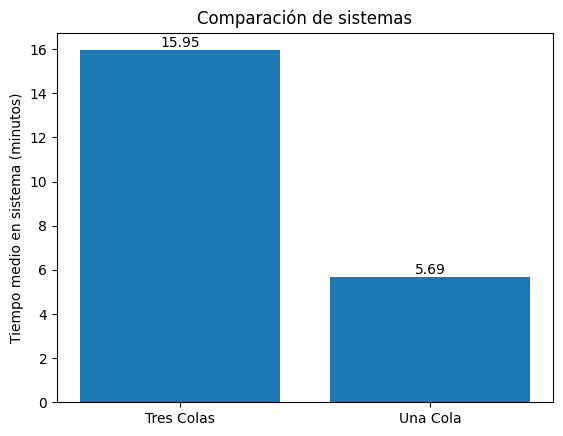

In [43]:
# Crear la figura y los ejes
fig, ax = plt.subplots()
barras = ax.bar(["Tres Colas", "Una Cola"], [media_tres_colas, media_una_cola])

# Agregar etiquetas de valores directamente con bar_label
ax.bar_label(barras, fmt="%.2f")

# Etiquetas
ax.set_ylabel("Tiempo medio en sistema (minutos)")
ax.set_title("Comparación de sistemas")

# Mostrar la gráfica
plt.show()